<a href="https://colab.research.google.com/github/Arash-Razi/ML_Dr_Aliyari_Course_2025/blob/main/MiniP3/ML2025_MiniP3_Q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [ ]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Define problem data
X = np.array([
    [1, -1, 1],   # x1, class -1
    [-3, 1, 1],   # x2, class 1
    [-3, 1, -1],  # x3, class -1
    [1, 2, 1],    # x4, class -1
    [-1, -1, 2]   # x5, class 1
])

y = np.array([-1, 1, -1, -1, 1])
n_samples = len(y)

print("=== Complete SVM Solution ===")
print(f"Input data:")
for i in range(n_samples):
    print(f"X^({i+1}) = {X[i]} → class = {y[i]}")

# Compute kernel matrix (linear kernel)
def linear_kernel(xi, xj):
    return np.dot(xi, xj)

K = np.zeros((n_samples, n_samples))
print(f"\nComputing kernel matrix K:")
for i in range(n_samples):
    for j in range(n_samples):
        K[i, j] = linear_kernel(X[i], X[j])
        print(f"K({i+1},{j+1}) = {K[i, j]:.1f}")

print(f"\nKernel matrix K:")
print(K)

# Compute matrix Q = y_i * y_j * K(xi, xj)
Q = np.outer(y, y) * K
print(f"\nMatrix Q = y_i * y_j * K(xi, xj):")
print(Q)

# Define dual objective function for SVM
def svm_dual_objective(alpha):
    """
    Dual objective function of SVM: φ(α) = Σα_i - (1/2)Σα_iα_jy_iy_jK(xi,xj)
    """
    return -np.sum(alpha) + 0.5 * np.dot(alpha, np.dot(Q, alpha))

# Define gradient of the objective function
def svm_dual_gradient(alpha):
    """
    Gradient of the objective function: ∇φ(α) = -1 + Qα
    """
    return -np.ones(n_samples) + np.dot(Q, alpha)

# QP Solver using Sequential Minimal Optimization (SMO)
class SMO_Solver:
    def __init__(self, Q, tolerance=1e-3, max_iterations=1000):
        self.Q = Q
        self.n = Q.shape[0]
        self.tolerance = tolerance
        self.max_iterations = max_iterations

    def solve(self):
        # Initial values
        alpha = np.zeros(self.n)

        print(f"\n=== Starting SMO algorithm ===")

        for iteration in range(self.max_iterations):
            alpha_old = alpha.copy()

            # Select two variables to optimize
            for i in range(self.n):
                for j in range(i + 1, self.n):
                    # Compute errors
                    Ei = self._calculate_error(alpha, i)
                    Ej = self._calculate_error(alpha, j)

                    # Check KKT conditions
                    if self._violates_kkt(alpha, i, Ei) or self._violates_kkt(alpha, j, Ej):
                        # Optimize pair (i, j)
                        alpha = self._optimize_pair(alpha, i, j)

            # Check for convergence
            if np.allclose(alpha, alpha_old, atol=self.tolerance):
                print(f"Converged at iteration {iteration + 1}")
                break

            if iteration % 100 == 0:
                print(f"Iteration {iteration}: α = {alpha}")

        return alpha

    def _calculate_error(self, alpha, i):
        """Compute prediction error"""
        decision_value = 0
        for k in range(self.n):
            decision_value += alpha[k] * y[k] * self.Q[k, i]
        return decision_value - y[i]

    def _violates_kkt(self, alpha, i, Ei):
        """Check KKT condition violation"""
        yi_Ei = y[i] * Ei
        if (alpha[i] < self.tolerance and yi_Ei < -self.tolerance):
            return True
        if (alpha[i] > self.tolerance and yi_Ei > self.tolerance):
            return True
        return False

    def _optimize_pair(self, alpha, i, j):
        """Optimize pair (i, j)"""
        alpha_new = alpha.copy()

        # Compute new bounds
        if y[i] != y[j]:
            L = max(0, alpha[j] - alpha[i])
            H = min(1, 1 + alpha[j] - alpha[i])  # Assume C=1
        else:
            L = max(0, alpha[i] + alpha[j] - 1)
            H = min(1, alpha[i] + alpha[j])

        if L == H:
            return alpha

        # Compute η
        eta = 2 * self.Q[i, j] - self.Q[i, i] - self.Q[j, j]
        if eta >= 0:
            return alpha

        # Compute new alpha
        Ei = self._calculate_error(alpha, i)
        Ej = self._calculate_error(alpha, j)

        alpha_j_new = alpha[j] - y[j] * (Ei - Ej) / eta
        alpha_j_new = max(L, min(H, alpha_j_new))

        if abs(alpha_j_new - alpha[j]) < 1e-5:
            return alpha

        alpha_i_new = alpha[i] + y[i] * y[j] * (alpha[j] - alpha_j_new)

        alpha_new[i] = alpha_i_new
        alpha_new[j] = alpha_j_new

        return alpha_new

# Solve the problem using SMO
smo_solver = SMO_Solver(Q)
alpha_optimal = smo_solver.solve()

print(f"\n=== Optimization Results ===")
print(f"Optimal Lagrange multipliers (α):")
for i in range(n_samples):
    print(f"α_{i+1} = {alpha_optimal[i]:.6f}")

# Identify Support Vectors
support_vectors = []
support_vector_indices = []
tolerance = 1e-5

print(f"\n=== Support Vector Detection ===")
for i in range(n_samples):
    if alpha_optimal[i] > tolerance:
        support_vectors.append(X[i])
        support_vector_indices.append(i)
        print(f"Point {i+1}: X^({i+1}) = {X[i]}, α_{i+1} = {alpha_optimal[i]:.6f} ← Support Vector")

print(f"\nNumber of Support Vectors: {len(support_vectors)}")

# Compute weights (w) for decision boundary
w = np.zeros(3)  # For 3D space
for i in range(n_samples):
    w += alpha_optimal[i] * y[i] * X[i]

print(f"\nWeight vector (w): {w}")

# Compute bias (b)
b_values = []
for i in support_vector_indices:
    b_i = y[i]
    for j in range(n_samples):
        b_i -= alpha_optimal[j] * y[j] * K[j, i]
    b_values.append(b_i)

b = np.mean(b_values) if b_values else 0
print(f"Bias (b): {b:.6f}")

# Define decision function
def decision_function(x):
    """Decision function: f(x) = w^T x + b"""
    return np.dot(w, x) + b

def predict(x):
    """Predict class"""
    return 1 if decision_function(x) >= 0 else -1

# Test on training data
print(f"\n=== Testing on Training Data ===")
correct_predictions = 0
for i in range(n_samples):
    predicted = predict(X[i])
    actual = y[i]
    decision_val = decision_function(X[i])
    print(f"X^({i+1}) = {X[i]}: predicted = {predicted:2d}, actual = {actual:2d}, f(x) = {decision_val:.3f}")
    if predicted == actual:
        correct_predictions += 1

accuracy = correct_predictions / n_samples * 100
print(f"\nAccuracy: {accuracy:.1f}% ({correct_predictions}/{n_samples})")

# Compute margin
margin = 2 / np.linalg.norm(w)
print(f"Margin: {margin:.6f}")

print(f"\n=== Summary of Results ===")
print(f"Number of Support Vectors: {len(support_vectors)}")
print(f"Weight vector: w = [{w[0]:.3f}, {w[1]:.3f}, {w[2]:.3f}]")
print(f"Bias: b = {b:.6f}")
print(f"Decision hyperplane: {w[0]:.3f}x₁ + {w[1]:.3f}x₂ + {w[2]:.3f}x₃ + {b:.6f} = 0")
print(f"Margin: {margin:.6f}")
print(f"Accuracy: {accuracy:.1f}%")

# Final result display
print(f"\n" + "="*50)
print(f"Final Result of SVM Problem Solving")
print(f"="*50)
print(f"Using Sequential Minimal Optimization (SMO) algorithm")
print(f"SVM problem was successfully solved.")
print(f"The optimal separating hyperplane with maximum margin was found.")


=== Complete SVM Solution ===
Input data:
X^(1) = [ 1 -1  1] → class = -1
X^(2) = [-3  1  1] → class = 1
X^(3) = [-3  1 -1] → class = -1
X^(4) = [1 2 1] → class = -1
X^(5) = [-1 -1  2] → class = 1

Computing kernel matrix K:
K(1,1) = 3.0
K(1,2) = -3.0
K(1,3) = -5.0
K(1,4) = 0.0
K(1,5) = 2.0
K(2,1) = -3.0
K(2,2) = 11.0
K(2,3) = 9.0
K(2,4) = 0.0
K(2,5) = 4.0
K(3,1) = -5.0
K(3,2) = 9.0
K(3,3) = 11.0
K(3,4) = -2.0
K(3,5) = 0.0
K(4,1) = 0.0
K(4,2) = 0.0
K(4,3) = -2.0
K(4,4) = 6.0
K(4,5) = -1.0
K(5,1) = 2.0
K(5,2) = 4.0
K(5,3) = 0.0
K(5,4) = -1.0
K(5,5) = 6.0

Kernel matrix K:
[[ 3. -3. -5.  0.  2.]
 [-3. 11.  9.  0.  4.]
 [-5.  9. 11. -2.  0.]
 [ 0.  0. -2.  6. -1.]
 [ 2.  4.  0. -1.  6.]]

Matrix Q = y_i * y_j * K(xi, xj):
[[ 3.  3. -5.  0. -2.]
 [ 3. 11. -9. -0.  4.]
 [-5. -9. 11. -2. -0.]
 [ 0. -0. -2.  6.  1.]
 [-2.  4. -0.  1.  6.]]

=== Starting SMO algorithm ===
Iteration 0: α = [0.25       0.19444444 0.         0.04444444 0.1       ]
Converged at iteration 7

=== Optimization Result

In [ ]:
!pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
beijing_pm2_5 = fetch_ucirepo(id=381)

# data (as pandas dataframes)
X = beijing_pm2_5.data.features
y = beijing_pm2_5.data.targets

# metadata
print(beijing_pm2_5.metadata)

# variable information
print(beijing_pm2_5.variables)


{'uci_id': 381, 'name': 'Beijing PM2.5', 'repository_url': 'https://archive.ics.uci.edu/dataset/381/beijing+pm2+5+data', 'data_url': 'https://archive.ics.uci.edu/static/public/381/data.csv', 'abstract': 'This hourly data set contains the PM2.5 data of US Embassy in Beijing. Meanwhile, meteorological data from Beijing Capital International Airport are also included. ', 'area': 'Climate and Environment', 'tasks': ['Regression'], 'characteristics': ['Multivariate', 'Time-Series'], 'num_instances': 43824, 'num_features': 11, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': ['pm2.5'], 'index_col': ['No'], 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2015, 'last_updated': 'Sat Mar 16 2024', 'dataset_doi': '10.24432/C5JS49', 'creators': ['Song Chen'], 'intro_paper': {'ID': 432, 'type': 'NATIVE', 'title': "Assessing Beijing's PM2.5 pollution: severity, weather impact, APEC and winter heating", 'authors': 'Xuan Liang, T. Zou, Bi

In [ ]:
df = pd.concat([X,y],axis=1)
df

,year,month,day,hour,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,pm2.5
0,2010,1,1,0,-21,-11.0,1021.0,NW,1.79,0,0,NaN
1,2010,1,1,1,-21,-12.0,1020.0,NW,4.92,0,0,NaN
2,2010,1,1,2,-21,-11.0,1019.0,NW,6.71,0,0,NaN
3,2010,1,1,3,-21,-14.0,1019.0,NW,9.84,0,0,NaN
4,2010,1,1,4,-20,-12.0,1018.0,NW,12.97,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
43819,2014,12,31,19,-23,-2.0,1034.0,NW,231.97,0,0,8.0
43820,2014,12,31,20,-22,-3.0,1034.0,NW,237.78,0,0,10.0
43821,2014,12,31,21,-22,-3.0,1034.0,NW,242.70,0,0,10.0
43822,2014,12,31,22,-22,-4.0,1034.0,NW,246.72,0,0,8.0


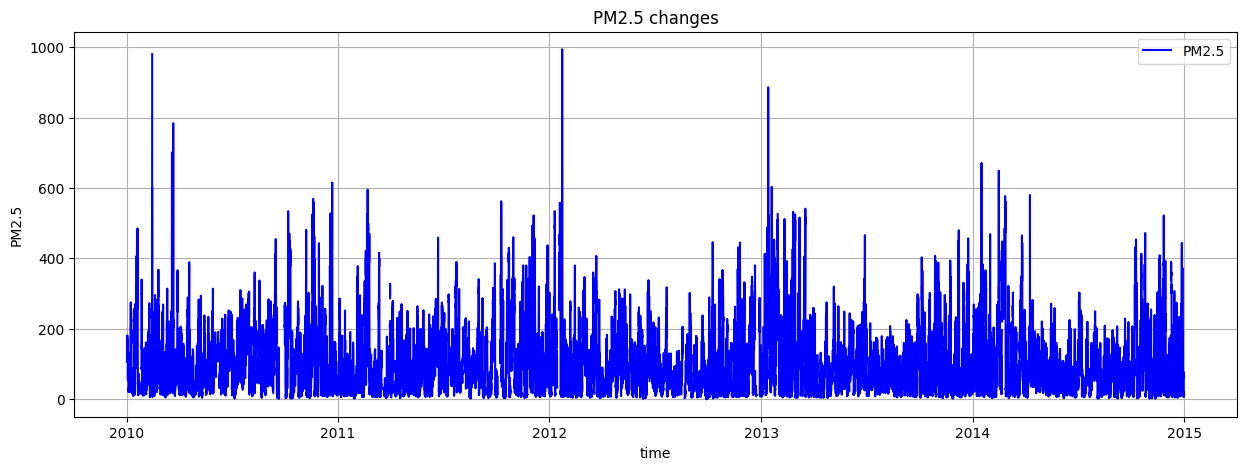

In [ ]:
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
plt.figure(figsize=(15, 5))
plt.plot(df['datetime'], df['pm2.5'], label='PM2.5', color='blue')
plt.xlabel('time')
plt.ylabel('PM2.5')
plt.title('PM2.5 changes')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
df2 = df.isna().sum()
df2

,0
year,0
month,0
day,0
hour,0
DEWP,0
TEMP,0
PRES,0
cbwd,0
Iws,0
Is,0


In [ ]:
df_filled = df[24:].fillna(method='ffill')
df_filled['pm2.5'].isna().sum()
df_filled.reset_index(drop=True,inplace=True)
df_filled = df_filled.drop(['datetime'],axis=1)
df_filled

<ipython-input-14-61ab0f6de296>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled = df[24:].fillna(method='ffill')


,year,month,day,hour,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,pm2.5
0,2010,1,2,0,-16,-4.0,1020.0,SE,1.79,0,0,129.0
1,2010,1,2,1,-15,-4.0,1020.0,SE,2.68,0,0,148.0
2,2010,1,2,2,-11,-5.0,1021.0,SE,3.57,0,0,159.0
3,2010,1,2,3,-7,-5.0,1022.0,SE,5.36,1,0,181.0
4,2010,1,2,4,-7,-5.0,1022.0,SE,6.25,2,0,138.0
...,...,...,...,...,...,...,...,...,...,...,...,...
43795,2014,12,31,19,-23,-2.0,1034.0,NW,231.97,0,0,8.0
43796,2014,12,31,20,-22,-3.0,1034.0,NW,237.78,0,0,10.0
43797,2014,12,31,21,-22,-3.0,1034.0,NW,242.70,0,0,10.0
43798,2014,12,31,22,-22,-4.0,1034.0,NW,246.72,0,0,8.0


In [ ]:
print(df_filled['cbwd'].unique())
values = df_filled['cbwd'].values
print(values)

['SE' 'cv' 'NW' 'NE']
['SE' 'SE' 'SE' ... 'NW' 'NW' 'NW']


In [ ]:
encoder = LabelEncoder()
values_changed = encoder.fit_transform(values)
print(values_changed)
df_filled['cbwd_numerical'] = values_changed
df_filled

[2 2 2 ... 1 1 1]


,year,month,day,hour,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,pm2.5,cbwd_numerical
0,2010,1,2,0,-16,-4.0,1020.0,SE,1.79,0,0,129.0,2
1,2010,1,2,1,-15,-4.0,1020.0,SE,2.68,0,0,148.0,2
2,2010,1,2,2,-11,-5.0,1021.0,SE,3.57,0,0,159.0,2
3,2010,1,2,3,-7,-5.0,1022.0,SE,5.36,1,0,181.0,2
4,2010,1,2,4,-7,-5.0,1022.0,SE,6.25,2,0,138.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43795,2014,12,31,19,-23,-2.0,1034.0,NW,231.97,0,0,8.0,1
43796,2014,12,31,20,-22,-3.0,1034.0,NW,237.78,0,0,10.0,1
43797,2014,12,31,21,-22,-3.0,1034.0,NW,242.70,0,0,10.0,1
43798,2014,12,31,22,-22,-4.0,1034.0,NW,246.72,0,0,8.0,1


In [ ]:
columns = ['pm2.5', 'TEMP', 'DEWP', 'Iws']

for col in columns:
    Q1 = df_filled[col].quantile(0.25)
    Q3 = df_filled[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df_filled[(df_filled[col] < lower_bound) | (df_filled[col] > upper_bound)]

    print(f"{col}: no. outliers = {outliers.shape[0]}")

pm2.5: no. outliers = 1857
TEMP: no. outliers = 0
DEWP: no. outliers = 0
Iws: no. outliers = 5101


In [ ]:
columns_to_be_clipped = {'pm2.5','Iws'}
df_model = df_filled.copy()
for col in columns_to_be_clipped:
    Q1 = df_model[col].quantile(0.25)
    Q3 = df_model[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    df_model[col] = df_model[col].clip(lower, upper)

for col in columns:
    Q1 = df_model[col].quantile(0.25)
    Q3 = df_model[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df_model[(df_model[col] < lower_bound) | (df_model[col] > upper_bound)]

    print(f"{col}: no. outliers = {outliers.shape[0]}")

pm2.5: no. outliers = 0
TEMP: no. outliers = 0
DEWP: no. outliers = 0
Iws: no. outliers = 0


In [ ]:
df_added_AQI = df_model.copy()
def categorize_aqi(pm25):
    if pm25 <= 12.0:
        return 'Good'
    elif pm25 <= 35.4:
        return 'Moderate'
    elif pm25 <= 55.4:
        return 'Unhealthy for Sensitive Groups'
    elif pm25 <= 150.4:
        return 'Unhealthy'
    elif pm25 <= 250.4:
        return 'Very Unhealthy'
    else:
        return 'Hazardous'

# Apply to your DataFrame (assume it's named df)
df_added_AQI['AQI_Category'] = df_model['pm2.5'].apply(categorize_aqi)
df_added_AQI

,year,month,day,hour,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,pm2.5,cbwd_numerical,AQI_Category
0,2010,1,2,0,-16,-4.0,1020.0,SE,1.79,0,0,129.0,2,Unhealthy
1,2010,1,2,1,-15,-4.0,1020.0,SE,2.68,0,0,148.0,2,Unhealthy
2,2010,1,2,2,-11,-5.0,1021.0,SE,3.57,0,0,159.0,2,Very Unhealthy
3,2010,1,2,3,-7,-5.0,1022.0,SE,5.36,1,0,181.0,2,Very Unhealthy
4,2010,1,2,4,-7,-5.0,1022.0,SE,6.25,2,0,138.0,2,Unhealthy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43795,2014,12,31,19,-23,-2.0,1034.0,NW,52.09,0,0,8.0,1,Good
43796,2014,12,31,20,-22,-3.0,1034.0,NW,52.09,0,0,10.0,1,Good
43797,2014,12,31,21,-22,-3.0,1034.0,NW,52.09,0,0,10.0,1,Good
43798,2014,12,31,22,-22,-4.0,1034.0,NW,52.09,0,0,8.0,1,Good


In [ ]:
df_added_lag = df_added_AQI.copy()
# Create lag feature for 2 hours prior
df_added_lag['pm2.5_lag_2h'] = df_added_AQI['pm2.5'].shift(2)

# Create lag feature for 24 hours prior
df_added_lag['pm2.5_lag_24h'] = df_added_AQI['pm2.5'].shift(24)
df_added_lag

,year,month,day,hour,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,pm2.5,cbwd_numerical,AQI_Category,pm2.5_lag_2h,pm2.5_lag_24h
0,2010,1,2,0,-16,-4.0,1020.0,SE,1.79,0,0,129.0,2,Unhealthy,NaN,NaN
1,2010,1,2,1,-15,-4.0,1020.0,SE,2.68,0,0,148.0,2,Unhealthy,NaN,NaN
2,2010,1,2,2,-11,-5.0,1021.0,SE,3.57,0,0,159.0,2,Very Unhealthy,129.0,NaN
3,2010,1,2,3,-7,-5.0,1022.0,SE,5.36,1,0,181.0,2,Very Unhealthy,148.0,NaN
4,2010,1,2,4,-7,-5.0,1022.0,SE,6.25,2,0,138.0,2,Unhealthy,159.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43795,2014,12,31,19,-23,-2.0,1034.0,NW,52.09,0,0,8.0,1,Good,9.0,35.0
43796,2014,12,31,20,-22,-3.0,1034.0,NW,52.09,0,0,10.0,1,Good,10.0,26.0
43797,2014,12,31,21,-22,-3.0,1034.0,NW,52.09,0,0,10.0,1,Good,8.0,20.0
43798,2014,12,31,22,-22,-4.0,1034.0,NW,52.09,0,0,8.0,1,Good,10.0,8.0


In [ ]:
df_added_lag_clean=df_added_lag.dropna(subset=['pm2.5_lag_2h', 'pm2.5_lag_24h'])
df_added_lag_clean.reset_index(drop=True,inplace=True)
display(df_added_lag_clean)

,year,month,day,hour,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,pm2.5,cbwd_numerical,AQI_Category,pm2.5_lag_2h,pm2.5_lag_24h
0,2010,1,3,0,-7,-6.0,1027.0,SE,52.09,4,0,90.0,2,Unhealthy,156.0,129.0
1,2010,1,3,1,-8,-6.0,1026.0,SE,52.09,5,0,63.0,2,Unhealthy,126.0,148.0
2,2010,1,3,2,-8,-7.0,1026.0,SE,52.09,6,0,65.0,2,Unhealthy,90.0,159.0
3,2010,1,3,3,-8,-7.0,1025.0,SE,52.09,7,0,55.0,2,Unhealthy for Sensitive Groups,63.0,181.0
4,2010,1,3,4,-8,-7.0,1024.0,SE,52.09,8,0,65.0,2,Unhealthy,65.0,138.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43771,2014,12,31,19,-23,-2.0,1034.0,NW,52.09,0,0,8.0,1,Good,9.0,35.0
43772,2014,12,31,20,-22,-3.0,1034.0,NW,52.09,0,0,10.0,1,Good,10.0,26.0
43773,2014,12,31,21,-22,-3.0,1034.0,NW,52.09,0,0,10.0,1,Good,8.0,20.0
43774,2014,12,31,22,-22,-4.0,1034.0,NW,52.09,0,0,8.0,1,Good,10.0,8.0


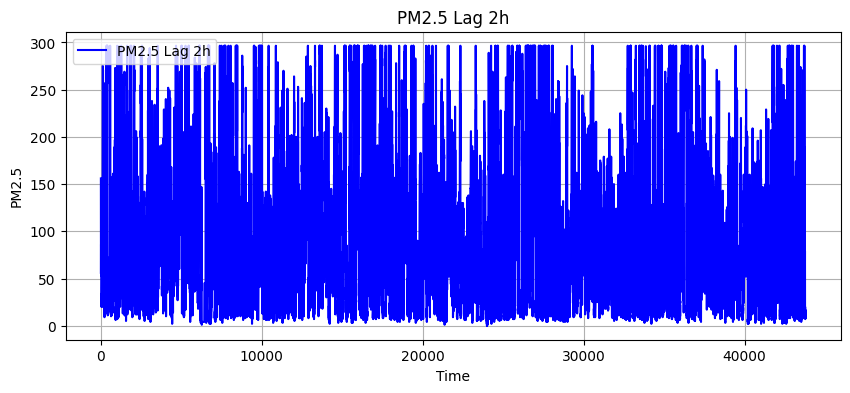

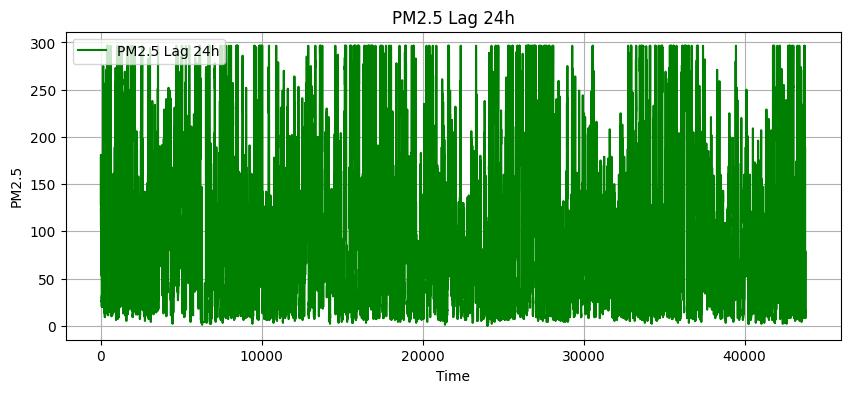

In [ ]:
import matplotlib.pyplot as plt

# Plot lag 2h
plt.figure(figsize=(10, 4))
plt.plot(df_added_lag_clean['pm2.5_lag_2h'], label='PM2.5 Lag 2h', color='blue')
plt.title('PM2.5 Lag 2h')
plt.xlabel('Time')
plt.ylabel('PM2.5')
plt.legend()
plt.grid(True)
plt.show()

# Plot lag 24h
plt.figure(figsize=(10, 4))
plt.plot(df_added_lag_clean['pm2.5_lag_24h'], label='PM2.5 Lag 24h', color='green')
plt.title('PM2.5 Lag 24h')
plt.xlabel('Time')
plt.ylabel('PM2.5')
plt.legend()
plt.grid(True)
plt.show()


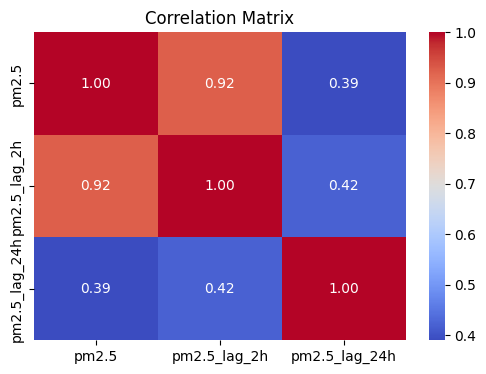

In [ ]:
import seaborn as sns

# Select relevant columns
corr_df = df_added_lag_clean[['pm2.5', 'pm2.5_lag_2h', 'pm2.5_lag_24h']]

# Compute correlation matrix
corr_matrix = corr_df.corr()

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


In [ ]:
df_added_rolling = df_added_lag_clean.copy()
df_added_rolling['pm2.5_roll_mean_24h'] = df_added_lag_clean['pm2.5'].rolling(window=24).mean()
df_added_rolling

,year,month,day,hour,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,pm2.5,cbwd_numerical,AQI_Category,pm2.5_lag_2h,pm2.5_lag_24h,pm2.5_roll_mean_24h
0,2010,1,3,0,-7,-6.0,1027.0,SE,52.09,4,0,90.0,2,Unhealthy,156.0,129.0,NaN
1,2010,1,3,1,-8,-6.0,1026.0,SE,52.09,5,0,63.0,2,Unhealthy,126.0,148.0,NaN
2,2010,1,3,2,-8,-7.0,1026.0,SE,52.09,6,0,65.0,2,Unhealthy,90.0,159.0,NaN
3,2010,1,3,3,-8,-7.0,1025.0,SE,52.09,7,0,55.0,2,Unhealthy for Sensitive Groups,63.0,181.0,NaN
4,2010,1,3,4,-8,-7.0,1024.0,SE,52.09,8,0,65.0,2,Unhealthy,65.0,138.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43771,2014,12,31,19,-23,-2.0,1034.0,NW,52.09,0,0,8.0,1,Good,9.0,35.0,11.291667
43772,2014,12,31,20,-22,-3.0,1034.0,NW,52.09,0,0,10.0,1,Good,10.0,26.0,10.625000
43773,2014,12,31,21,-22,-3.0,1034.0,NW,52.09,0,0,10.0,1,Good,8.0,20.0,10.208333
43774,2014,12,31,22,-22,-4.0,1034.0,NW,52.09,0,0,8.0,1,Good,10.0,8.0,10.208333


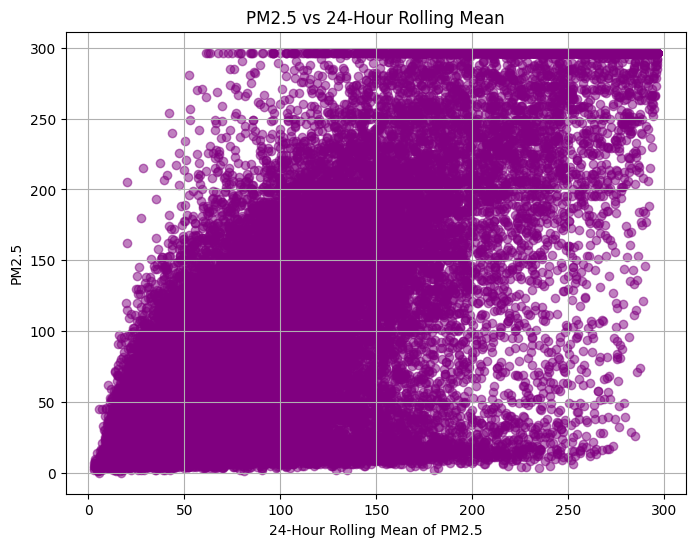

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(df_added_rolling['pm2.5_roll_mean_24h'], df_added_rolling['pm2.5'], alpha=0.5, color='purple')

plt.title('PM2.5 vs 24-Hour Rolling Mean')
plt.xlabel('24-Hour Rolling Mean of PM2.5')
plt.ylabel('PM2.5')
plt.grid(True)
plt.show()

In [ ]:
df_added_encoding = df_added_rolling.copy()

# Encoding the periodic features
df_added_encoding['hour_sin'] = np.sin(2 * np.pi * df_added_encoding['hour'] / 24)
df_added_encoding['hour_cos'] = np.cos(2 * np.pi * df_added_encoding['hour'] / 24)

df_added_encoding['day_sin'] = np.sin(2 * np.pi * df_added_encoding['day'] / 365)
df_added_encoding['day_cos'] = np.cos(2 * np.pi * df_added_encoding['day'] / 365)

# If you're modeling over multiple years and want to encode yearly seasonality:
# Normalize year (e.g., start from 0) before encoding
df_added_encoding['year_norm'] = df_added_encoding['year'] - df_added_encoding['year'].min()
df_added_encoding['year_sin'] = np.sin(2 * np.pi * df_added_encoding['year_norm'] / (df_added_encoding['year_norm'].max() + 1))
df_added_encoding['year_cos'] = np.cos(2 * np.pi * df_added_encoding['year_norm'] / (df_added_encoding['year_norm'].max() + 1))

df_added_encoding


,year,month,day,hour,DEWP,TEMP,PRES,cbwd,Iws,Is,...,pm2.5_lag_2h,pm2.5_lag_24h,pm2.5_roll_mean_24h,hour_sin,hour_cos,day_sin,day_cos,year_norm,year_sin,year_cos
0,2010,1,3,0,-7,-6.0,1027.0,SE,52.09,4,...,156.0,129.0,NaN,0.000000,1.000000,0.051620,0.998667,0,0.000000,1.000000
1,2010,1,3,1,-8,-6.0,1026.0,SE,52.09,5,...,126.0,148.0,NaN,0.258819,0.965926,0.051620,0.998667,0,0.000000,1.000000
2,2010,1,3,2,-8,-7.0,1026.0,SE,52.09,6,...,90.0,159.0,NaN,0.500000,0.866025,0.051620,0.998667,0,0.000000,1.000000
3,2010,1,3,3,-8,-7.0,1025.0,SE,52.09,7,...,63.0,181.0,NaN,0.707107,0.707107,0.051620,0.998667,0,0.000000,1.000000
4,2010,1,3,4,-8,-7.0,1024.0,SE,52.09,8,...,65.0,138.0,NaN,0.866025,0.500000,0.051620,0.998667,0,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43771,2014,12,31,19,-23,-2.0,1034.0,NW,52.09,0,...,9.0,35.0,11.291667,-0.965926,0.258819,0.508671,0.860961,4,-0.951057,0.309017
43772,2014,12,31,20,-22,-3.0,1034.0,NW,52.09,0,...,10.0,26.0,10.625000,-0.866025,0.500000,0.508671,0.860961,4,-0.951057,0.309017
43773,2014,12,31,21,-22,-3.0,1034.0,NW,52.09,0,...,8.0,20.0,10.208333,-0.707107,0.707107,0.508671,0.860961,4,-0.951057,0.309017
43774,2014,12,31,22,-22,-4.0,1034.0,NW,52.09,0,...,10.0,8.0,10.208333,-0.500000,0.866025,0.508671,0.860961,4,-0.951057,0.309017


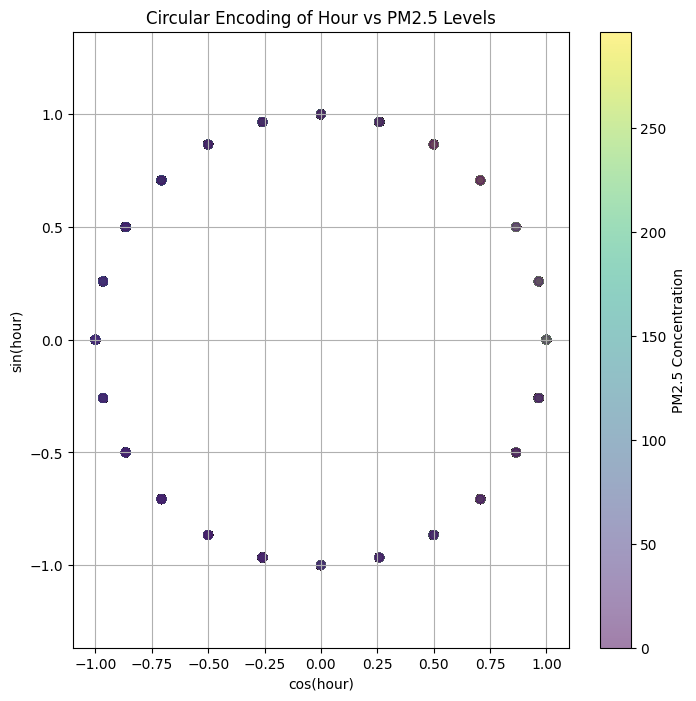

In [ ]:
# Make sure encoding is done
df_added_encoding['hour_sin'] = np.sin(2 * np.pi * df_added_encoding['hour'] / 24)
df_added_encoding['hour_cos'] = np.cos(2 * np.pi * df_added_encoding['hour'] / 24)

# Now, plot hour_sin vs hour_cos and color by PM2.5 concentration
plt.figure(figsize=(8, 8))
scatter = plt.scatter(df_added_encoding['hour_cos'], df_added_encoding['hour_sin'], c=df_added_encoding['pm2.5'], cmap='viridis', alpha=0.5)
plt.colorbar(scatter, label='PM2.5 Concentration')
plt.xlabel('cos(hour)')
plt.ylabel('sin(hour)')
plt.title('Circular Encoding of Hour vs PM2.5 Levels')
plt.grid(True)
plt.axis('equal')  # Keep the unit circle shape
plt.show()


In [ ]:
df_added_season = df_added_encoding.copy()
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df_added_season['season'] = df_added_encoding['month'].apply(get_season)
df_added_season

,year,month,day,hour,DEWP,TEMP,PRES,cbwd,Iws,Is,...,pm2.5_lag_24h,pm2.5_roll_mean_24h,hour_sin,hour_cos,day_sin,day_cos,year_norm,year_sin,year_cos,season
0,2010,1,3,0,-7,-6.0,1027.0,SE,52.09,4,...,129.0,NaN,0.000000,1.000000,0.051620,0.998667,0,0.000000,1.000000,Winter
1,2010,1,3,1,-8,-6.0,1026.0,SE,52.09,5,...,148.0,NaN,0.258819,0.965926,0.051620,0.998667,0,0.000000,1.000000,Winter
2,2010,1,3,2,-8,-7.0,1026.0,SE,52.09,6,...,159.0,NaN,0.500000,0.866025,0.051620,0.998667,0,0.000000,1.000000,Winter
3,2010,1,3,3,-8,-7.0,1025.0,SE,52.09,7,...,181.0,NaN,0.707107,0.707107,0.051620,0.998667,0,0.000000,1.000000,Winter
4,2010,1,3,4,-8,-7.0,1024.0,SE,52.09,8,...,138.0,NaN,0.866025,0.500000,0.051620,0.998667,0,0.000000,1.000000,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43771,2014,12,31,19,-23,-2.0,1034.0,NW,52.09,0,...,35.0,11.291667,-0.965926,0.258819,0.508671,0.860961,4,-0.951057,0.309017,Winter
43772,2014,12,31,20,-22,-3.0,1034.0,NW,52.09,0,...,26.0,10.625000,-0.866025,0.500000,0.508671,0.860961,4,-0.951057,0.309017,Winter
43773,2014,12,31,21,-22,-3.0,1034.0,NW,52.09,0,...,20.0,10.208333,-0.707107,0.707107,0.508671,0.860961,4,-0.951057,0.309017,Winter
43774,2014,12,31,22,-22,-4.0,1034.0,NW,52.09,0,...,8.0,10.208333,-0.500000,0.866025,0.508671,0.860961,4,-0.951057,0.309017,Winter


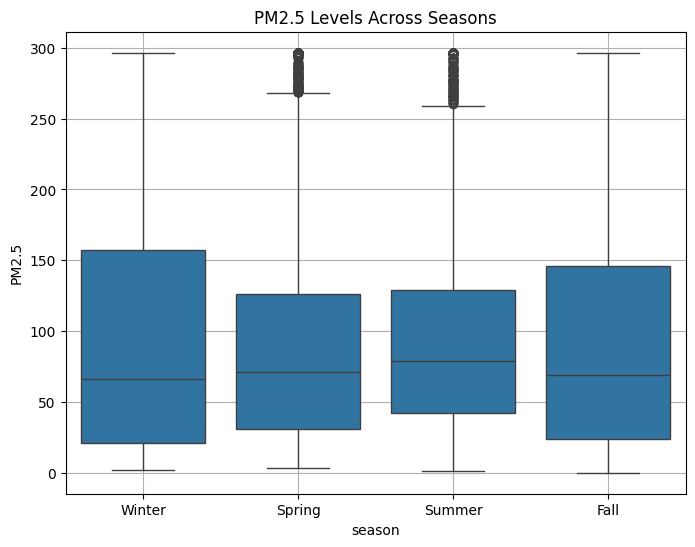

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='season', y='pm2.5', data=df_added_season, order=['Winter', 'Spring', 'Summer', 'Fall'])
plt.title('PM2.5 Levels Across Seasons')
plt.ylabel('PM2.5')
plt.grid(True)
plt.show()

2025-06-01 12:40:41,232 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-01 12:40:41,274 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


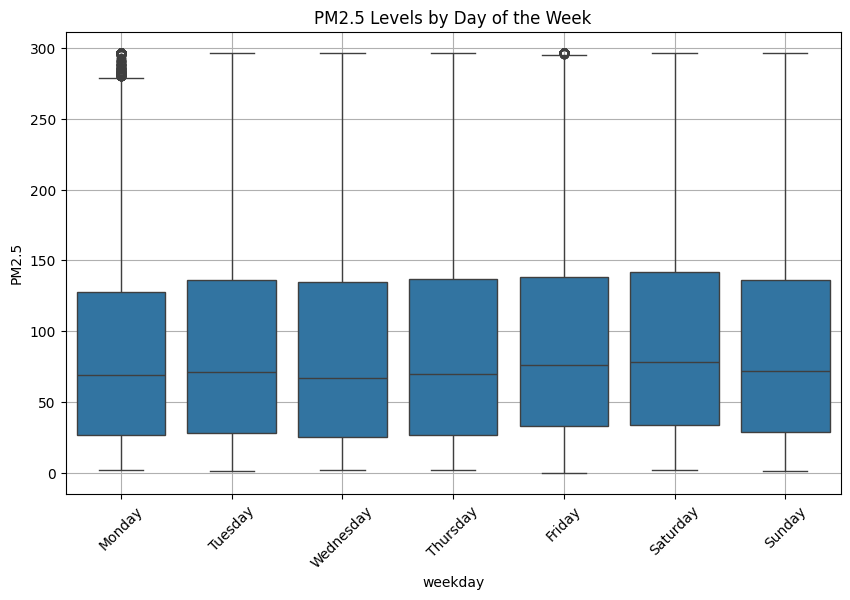

In [ ]:
df_added_season['datetime'] = pd.to_datetime(df_added_season[['year', 'month', 'day', 'hour']])
df_added_season['weekday'] = df_added_season['datetime'].dt.day_name()
plt.figure(figsize=(10, 6))
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.boxplot(x='weekday', y='pm2.5', data=df_added_season, order=order)
plt.title('PM2.5 Levels by Day of the Week')
plt.xticks(rotation=45)
plt.ylabel('PM2.5')
plt.grid(True)
plt.show()


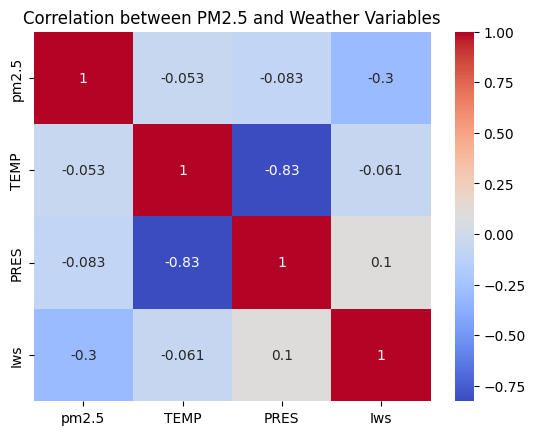

In [ ]:
corr_cols = ['pm2.5', 'TEMP', 'PRES', 'Iws']
correlation = df_added_season[corr_cols].corr()

sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation between PM2.5 and Weather Variables')
plt.show()

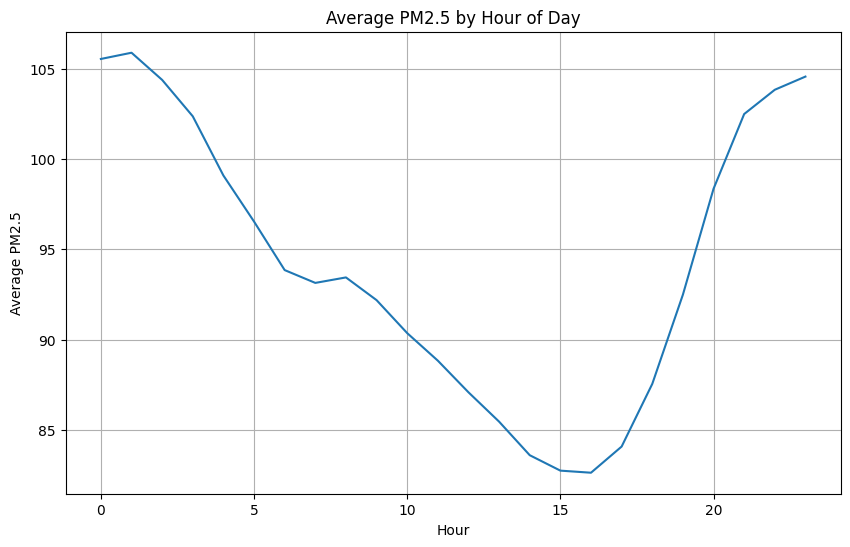

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='hour', y='pm2.5', data=df_added_season.groupby('hour')['pm2.5'].mean().reset_index())
plt.title('Average PM2.5 by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Average PM2.5')
plt.grid(True)
plt.show()


In [ ]:
df_added_season['datetime'] = pd.to_datetime(df_added_season[['year', 'month', 'day', 'hour']])
df_added_season

,year,month,day,hour,DEWP,TEMP,PRES,cbwd,Iws,Is,...,hour_sin,hour_cos,day_sin,day_cos,year_norm,year_sin,year_cos,season,datetime,weekday
0,2010,1,3,0,-7,-6.0,1027.0,SE,52.09,4,...,0.000000,1.000000,0.051620,0.998667,0,0.000000,1.000000,Winter,2010-01-03 00:00:00,Sunday
1,2010,1,3,1,-8,-6.0,1026.0,SE,52.09,5,...,0.258819,0.965926,0.051620,0.998667,0,0.000000,1.000000,Winter,2010-01-03 01:00:00,Sunday
2,2010,1,3,2,-8,-7.0,1026.0,SE,52.09,6,...,0.500000,0.866025,0.051620,0.998667,0,0.000000,1.000000,Winter,2010-01-03 02:00:00,Sunday
3,2010,1,3,3,-8,-7.0,1025.0,SE,52.09,7,...,0.707107,0.707107,0.051620,0.998667,0,0.000000,1.000000,Winter,2010-01-03 03:00:00,Sunday
4,2010,1,3,4,-8,-7.0,1024.0,SE,52.09,8,...,0.866025,0.500000,0.051620,0.998667,0,0.000000,1.000000,Winter,2010-01-03 04:00:00,Sunday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43771,2014,12,31,19,-23,-2.0,1034.0,NW,52.09,0,...,-0.965926,0.258819,0.508671,0.860961,4,-0.951057,0.309017,Winter,2014-12-31 19:00:00,Wednesday
43772,2014,12,31,20,-22,-3.0,1034.0,NW,52.09,0,...,-0.866025,0.500000,0.508671,0.860961,4,-0.951057,0.309017,Winter,2014-12-31 20:00:00,Wednesday
43773,2014,12,31,21,-22,-3.0,1034.0,NW,52.09,0,...,-0.707107,0.707107,0.508671,0.860961,4,-0.951057,0.309017,Winter,2014-12-31 21:00:00,Wednesday
43774,2014,12,31,22,-22,-4.0,1034.0,NW,52.09,0,...,-0.500000,0.866025,0.508671,0.860961,4,-0.951057,0.309017,Winter,2014-12-31 22:00:00,Wednesday


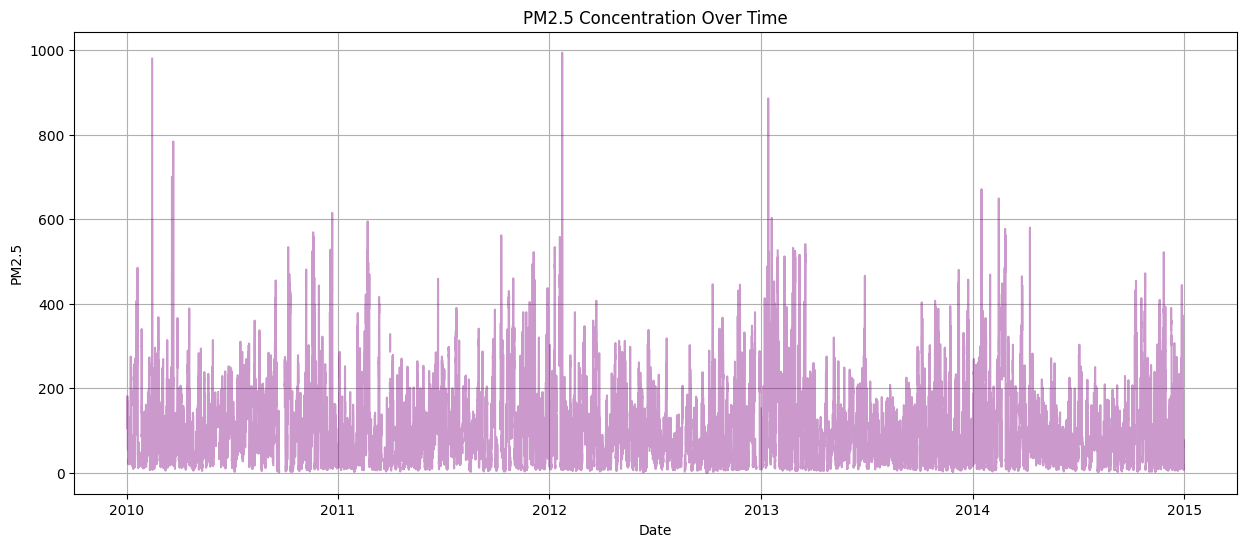

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(df['datetime'], df['pm2.5'], color='purple', alpha=0.4)
plt.title('PM2.5 Concentration Over Time')
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.grid(True)
plt.show()


In [ ]:
max_row = df.loc[df['pm2.5'].idxmax()]
print(f"Maximum Air pollution happend in {max_row['datetime']} with the value of {max_row['pm2.5']}")

Maximum Air pollution happend in 2012-01-23 01:00:00 with the value of 994.0


In [ ]:
df = df_added_AQI
df

,year,month,day,hour,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,pm2.5,cbwd_numerical,AQI_Category
0,2010,1,2,0,-16,-4.0,1020.0,SE,1.79,0,0,129.0,2,Unhealthy
1,2010,1,2,1,-15,-4.0,1020.0,SE,2.68,0,0,148.0,2,Unhealthy
2,2010,1,2,2,-11,-5.0,1021.0,SE,3.57,0,0,159.0,2,Very Unhealthy
3,2010,1,2,3,-7,-5.0,1022.0,SE,5.36,1,0,181.0,2,Very Unhealthy
4,2010,1,2,4,-7,-5.0,1022.0,SE,6.25,2,0,138.0,2,Unhealthy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43795,2014,12,31,19,-23,-2.0,1034.0,NW,52.09,0,0,8.0,1,Good
43796,2014,12,31,20,-22,-3.0,1034.0,NW,52.09,0,0,10.0,1,Good
43797,2014,12,31,21,-22,-3.0,1034.0,NW,52.09,0,0,10.0,1,Good
43798,2014,12,31,22,-22,-4.0,1034.0,NW,52.09,0,0,8.0,1,Good


AQI_Category
Unhealthy                         16405
Moderate                           9151
Very Unhealthy                     6160
Unhealthy for Sensitive Groups     5267
Good                               3707
Hazardous                          3110
Name: count, dtype: int64


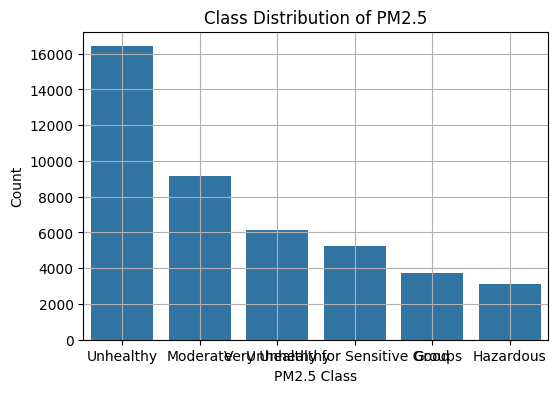

In [ ]:
class_counts = df['AQI_Category'].value_counts()
print(class_counts)

plt.figure(figsize=(6,4))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Class Distribution of PM2.5')
plt.ylabel('Count')
plt.xlabel('PM2.5 Class')
plt.grid(True)
plt.show()

,year,month,day,hour,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,pm2.5,cbwd_numerical,AQI_Category
0,2010,2,9,5,-6,-5.0,1022.0,NW,5.81,0,0,241.0,1,Very Unhealthy
1,2013,5,5,20,14,22.0,1014.0,SE,25.47,0,0,230.0,2,Very Unhealthy
2,2014,3,25,21,5,14.0,1009.0,SE,16.97,0,0,147.0,2,Unhealthy
3,2010,6,29,22,21,27.0,1003.0,SE,0.89,0,0,153.0,2,Very Unhealthy
4,2014,2,21,15,-6,4.0,1026.0,NE,1.79,0,0,296.5,0,Hazardous
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18655,2011,9,9,23,10,18.0,1023.0,NE,0.89,0,0,21.0,0,Moderate
18656,2014,7,2,2,20,21.0,1004.0,NE,1.79,0,0,34.0,0,Moderate
18657,2012,5,9,9,7,22.0,1015.0,cv,2.67,0,0,154.0,3,Very Unhealthy
18658,2011,5,11,7,14,15.0,1007.0,cv,0.89,0,0,106.0,3,Unhealthy


AQI_Category
Very Unhealthy                    3110
Unhealthy                         3110
Hazardous                         3110
Moderate                          3110
Good                              3110
Unhealthy for Sensitive Groups    3110
Name: count, dtype: int64


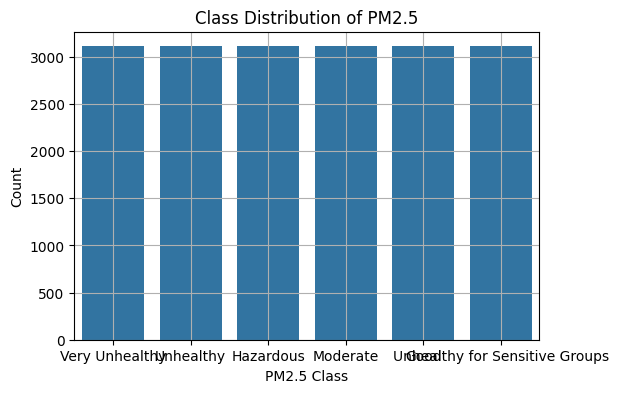

In [ ]:
from sklearn.utils import resample

df_aqi = df.dropna(subset=['AQI_Category'])

classes = df_aqi['AQI_Category'].unique()
min_count = df_aqi['AQI_Category'].value_counts().min()

balanced_parts = []
for cls in classes:
    cls_df = df_aqi[df_aqi['AQI_Category'] == cls]
    balanced_part = resample(cls_df, replace=False, n_samples=min_count, random_state=42)
    balanced_parts.append(balanced_part)

df_balanced_aqi = pd.concat(balanced_parts).sample(frac=1, random_state=42).reset_index(drop=True)

display(df_balanced_aqi)
class_counts = df_balanced_aqi['AQI_Category'].value_counts()
print(class_counts)

plt.figure(figsize=(6,4))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Class Distribution of PM2.5')
plt.ylabel('Count')
plt.xlabel('PM2.5 Class')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler

numerical_features = ['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir']

df_cleaned = df_balanced_aqi[numerical_features].dropna()

df_cleaned

df_cleaned['AQI_Category'] = df_cleaned['pm2.5'].apply(categorize_aqi)
df_cleaned

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,AQI_Category
0,241.0,-6,-5.0,1022.0,5.81,0,0,Very Unhealthy
1,230.0,14,22.0,1014.0,25.47,0,0,Very Unhealthy
2,147.0,5,14.0,1009.0,16.97,0,0,Unhealthy
3,153.0,21,27.0,1003.0,0.89,0,0,Very Unhealthy
4,296.5,-6,4.0,1026.0,1.79,0,0,Hazardous
...,...,...,...,...,...,...,...,...
18655,21.0,10,18.0,1023.0,0.89,0,0,Moderate
18656,34.0,20,21.0,1004.0,1.79,0,0,Moderate
18657,154.0,7,22.0,1015.0,2.67,0,0,Very Unhealthy
18658,106.0,14,15.0,1007.0,0.89,0,0,Unhealthy


In [ ]:
df_reg = df_added_season[24:].drop(columns=['datetime','season','weekday','cbwd'])
df_reg

,year,month,day,hour,DEWP,TEMP,PRES,Iws,Is,Ir,...,pm2.5_lag_2h,pm2.5_lag_24h,pm2.5_roll_mean_24h,hour_sin,hour_cos,day_sin,day_cos,year_norm,year_sin,year_cos
24,2010,1,4,0,-14,-12.0,1023.0,16.09,0,0,...,76.0,90.0,78.375000,0.000000,1.000000,0.068802,0.997630,0,0.000000,1.000000
25,2010,1,4,1,-16,-9.0,1023.0,21.90,0,0,...,73.0,63.0,78.166667,0.258819,0.965926,0.068802,0.997630,0,0.000000,1.000000
26,2010,1,4,2,-17,-10.0,1024.0,29.95,0,0,...,79.0,65.0,76.500000,0.500000,0.866025,0.068802,0.997630,0,0.000000,1.000000
27,2010,1,4,3,-18,-11.0,1024.0,39.78,0,0,...,58.0,55.0,75.291667,0.707107,0.707107,0.068802,0.997630,0,0.000000,1.000000
28,2010,1,4,4,-19,-11.0,1025.0,48.72,0,0,...,25.0,65.0,73.750000,0.866025,0.500000,0.068802,0.997630,0,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43771,2014,12,31,19,-23,-2.0,1034.0,52.09,0,0,...,9.0,35.0,11.291667,-0.965926,0.258819,0.508671,0.860961,4,-0.951057,0.309017
43772,2014,12,31,20,-22,-3.0,1034.0,52.09,0,0,...,10.0,26.0,10.625000,-0.866025,0.500000,0.508671,0.860961,4,-0.951057,0.309017
43773,2014,12,31,21,-22,-3.0,1034.0,52.09,0,0,...,8.0,20.0,10.208333,-0.707107,0.707107,0.508671,0.860961,4,-0.951057,0.309017
43774,2014,12,31,22,-22,-4.0,1034.0,52.09,0,0,...,10.0,8.0,10.208333,-0.500000,0.866025,0.508671,0.860961,4,-0.951057,0.309017


In [ ]:
X = df_cleaned.drop(columns=['AQI_Category','pm2.5'])
y = df_cleaned.loc[X.index, 'AQI_Category']
display(X)
display(y)

,DEWP,TEMP,PRES,Iws,Is,Ir
0,-6,-5.0,1022.0,5.81,0,0
1,14,22.0,1014.0,25.47,0,0
2,5,14.0,1009.0,16.97,0,0
3,21,27.0,1003.0,0.89,0,0
4,-6,4.0,1026.0,1.79,0,0
...,...,...,...,...,...,...
18655,10,18.0,1023.0,0.89,0,0
18656,20,21.0,1004.0,1.79,0,0
18657,7,22.0,1015.0,2.67,0,0
18658,14,15.0,1007.0,0.89,0,0


,AQI_Category
0,Very Unhealthy
1,Very Unhealthy
2,Unhealthy
3,Very Unhealthy
4,Hazardous
...,...
18655,Moderate
18656,Moderate
18657,Very Unhealthy
18658,Unhealthy


In [ ]:
encoder2 = LabelEncoder()
valuesd = y.values
Y = encoder2.fit_transform(valuesd)
y = pd.DataFrame(Y)
y

,0
0,5
1,5
2,3
3,5
4,1
...,...
18655,2
18656,2
18657,5
18658,3


In [ ]:
from sklearn.model_selection import train_test_split

X_class = beijing_pm2_5.data.features
y_class = beijing_pm2_5.data.targets

X_train, X_remain, y_train, y_remain = train_test_split(X, y, train_size=0.7, random_state=42, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(X_remain, y_remain, test_size=0.5, random_state=42, stratify=y_remain)

print(f"Train set: {len(X_train)}")
print(f"Validation set: {len(X_val)}")
print(f"Test set: {len(X_test)}")
display(X_train)

Train set: 13062
Validation set: 2799
Test set: 2799


,DEWP,TEMP,PRES,Iws,Is,Ir
9348,-3,28.0,1006.0,10.28,0,0
12478,-22,-8.0,1040.0,52.09,0,0
4343,-9,-8.0,1026.0,1.79,0,0
13980,21,23.0,1003.0,0.89,0,7
15607,27,32.0,1002.0,3.58,0,0
...,...,...,...,...,...,...
16880,16,28.0,1004.0,3.13,0,1
15335,-5,12.0,1017.0,52.09,0,0
14715,18,28.0,1008.0,6.25,0,0
3848,-7,2.0,1014.0,1.79,0,0


In [ ]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
type(X_train_scaled)

numpy.ndarray

In [ ]:
from sklearn.preprocessing import StandardScaler
sscaler = StandardScaler()
X_train_sscaled = sscaler.fit_transform(X_train)
X_test_sscaled = sscaler.transform(X_test)


In [ ]:
import pandas as pd

def downsample_balanced(X, y, total_samples=3000):
    # Ensure y is a flat Series
    if isinstance(y, pd.DataFrame):
        assert y.shape[1] == 1, "Expected y to be a single-column DataFrame"
        y = y.iloc[:, 0]

    # Combine X and y into one DataFrame
    df = X.copy()
    df['label_temp'] = y.reset_index(drop=True)  # Ensure aligned indexing

    # Compute number of samples per class
    n_classes = df['label_temp'].nunique()
    samples_per_class = total_samples // n_classes

    # Sample from each class
    df_balanced = (
        df.groupby('label_temp', group_keys=False)
          .apply(lambda x: x.sample(min(len(x), samples_per_class), random_state=42))
    )

    # Split X and y again
    y_balanced = df_balanced['label_temp']
    X_balanced = df_balanced.drop(columns=['label_temp'])

    return X_balanced, y_balanced


In [ ]:
X_test_series = X_test.iloc[:,0]
X_reduced, y_reduced = downsample_balanced(X_train, X_test_series)

<ipython-input-38-db249056cce9>:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min(len(x), samples_per_class), random_state=42))


In [ ]:
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(X_reduced, y_reduced, train_size=0.7, random_state=42)
print(X_train_reduced.shape)
print(y_train_reduced.shape)


(1334, 6)
(1334,)


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Example for lineara
svc_linear = SVC(kernel='linear')
svc_linear.fit(X_train_scaled, y_train)
y_pred_linear = svc_linear.predict(X_test_scaled)

# Similarly for RBF
svc_rbf = SVC(kernel='rbf')
svc_rbf.fit(X_train_scaled, y_train)
y_pred_rbf = svc_rbf.predict(X_test_scaled)

# Polynomial
svc_poly = SVC(kernel='poly', degree=3)
svc_poly.fit(X_train_scaled, y_train)
y_pred_poly = svc_poly.predict(X_test_scaled)



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Example for lineara
svc_linear_ss = SVC(kernel='linear')
svc_linear_ss.fit(X_train_sscaled, y_train)
y_pred_linear_ss = svc_linear_ss.predict(X_test_sscaled)

# Similarly for RBF
svc_rbf_ss = SVC(kernel='rbf')
svc_rbf_ss.fit(X_train_sscaled, y_train)
y_pred_rbf_ss = svc_rbf_ss.predict(X_test_sscaled)

# Polynomial
svc_poly_ss = SVC(kernel='poly', degree=3)
svc_poly_ss.fit(X_train_sscaled, y_train)
y_pred_poly_ss = svc_poly_ss.predict(X_test_sscaled)



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def evaluate_model(name, y_true, y_pred, labels=None):
    """
    Displays a classification report, accuracy, and a heatmap of the confusion matrix.
    """
    print(f"\n📊 Model: {name}")
    print("-" * 60)

    # Classification report
    report = classification_report(y_true, y_pred, target_names=labels, zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)
    print(report)
    print(f"✅ Accuracy: {accuracy:.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()



📊 Model: SVM Linear
------------------------------------------------------------
                  precision    recall  f1-score   support

            Good       0.46      0.47      0.46       466
        Moderate       0.41      0.70      0.51       466
Unhealthy for SG       0.30      0.26      0.28       467
       Unhealthy       0.29      0.21      0.24       467
  Very Unhealthy       0.19      0.10      0.13       467
       Hazardous       0.27      0.32      0.30       466

        accuracy                           0.34      2799
       macro avg       0.32      0.34      0.32      2799
    weighted avg       0.32      0.34      0.32      2799

✅ Accuracy: 0.3419


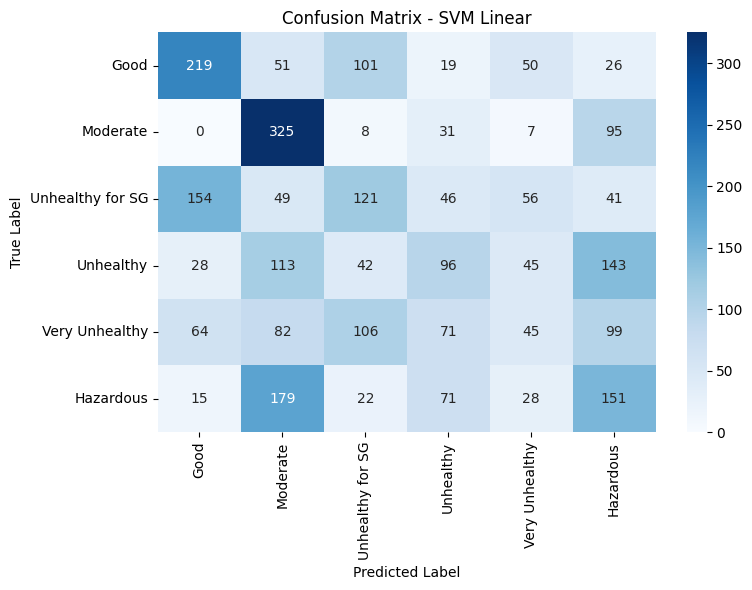


📊 Model: SVM RBF
------------------------------------------------------------
                  precision    recall  f1-score   support

            Good       0.47      0.54      0.50       466
        Moderate       0.45      0.73      0.56       466
Unhealthy for SG       0.35      0.20      0.26       467
       Unhealthy       0.33      0.37      0.35       467
  Very Unhealthy       0.27      0.20      0.23       467
       Hazardous       0.29      0.24      0.26       466

        accuracy                           0.38      2799
       macro avg       0.36      0.38      0.36      2799
    weighted avg       0.36      0.38      0.36      2799

✅ Accuracy: 0.3780


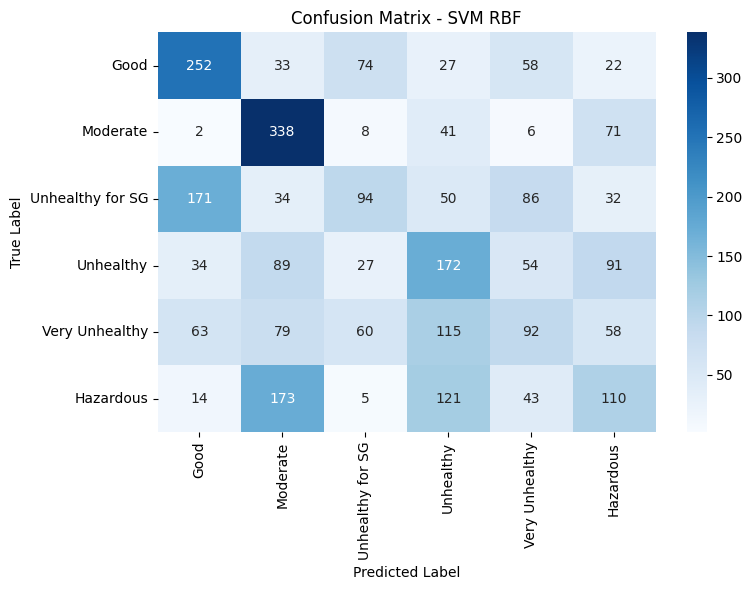


📊 Model: SVM Polynomial
------------------------------------------------------------
                  precision    recall  f1-score   support

            Good       0.48      0.47      0.47       466
        Moderate       0.44      0.73      0.55       466
Unhealthy for SG       0.35      0.21      0.26       467
       Unhealthy       0.30      0.25      0.27       467
  Very Unhealthy       0.26      0.21      0.23       467
       Hazardous       0.28      0.32      0.30       466

        accuracy                           0.36      2799
       macro avg       0.35      0.36      0.35      2799
    weighted avg       0.35      0.36      0.35      2799

✅ Accuracy: 0.3630


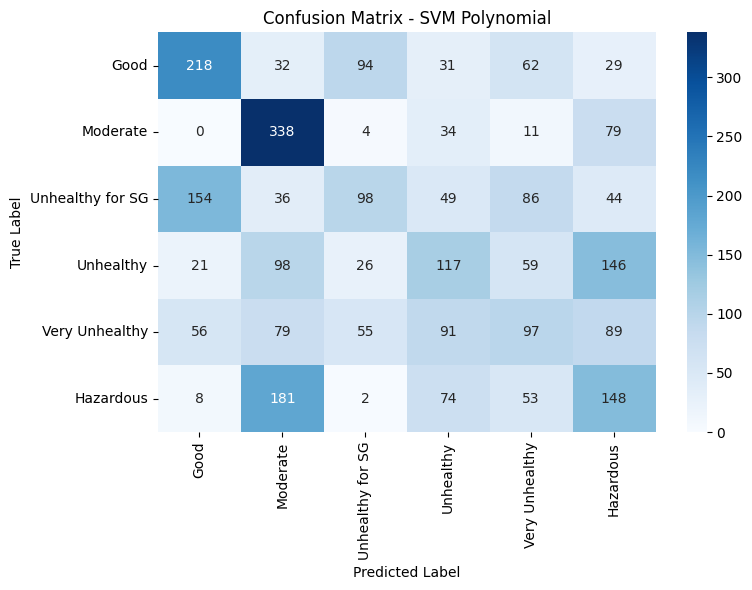


📊 Model: SVM Linear
------------------------------------------------------------
                  precision    recall  f1-score   support

            Good       0.46      0.47      0.47       466
        Moderate       0.41      0.70      0.51       466
Unhealthy for SG       0.30      0.27      0.28       467
       Unhealthy       0.28      0.19      0.22       467
  Very Unhealthy       0.20      0.11      0.14       467
       Hazardous       0.29      0.34      0.32       466

        accuracy                           0.35      2799
       macro avg       0.32      0.35      0.32      2799
    weighted avg       0.32      0.35      0.32      2799

✅ Accuracy: 0.3458


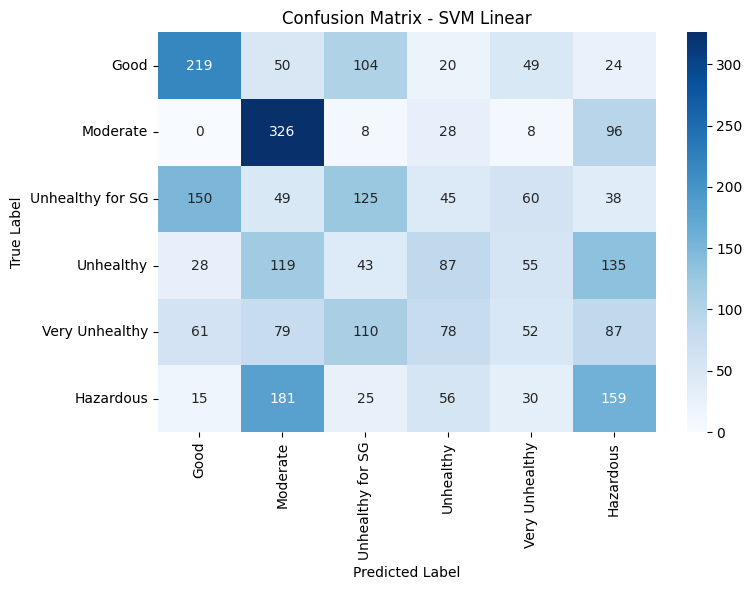


📊 Model: SVM RBF
------------------------------------------------------------
                  precision    recall  f1-score   support

            Good       0.48      0.56      0.52       466
        Moderate       0.46      0.75      0.57       466
Unhealthy for SG       0.36      0.23      0.28       467
       Unhealthy       0.33      0.32      0.33       467
  Very Unhealthy       0.29      0.21      0.25       467
       Hazardous       0.30      0.26      0.28       466

        accuracy                           0.39      2799
       macro avg       0.37      0.39      0.37      2799
    weighted avg       0.37      0.39      0.37      2799

✅ Accuracy: 0.3901


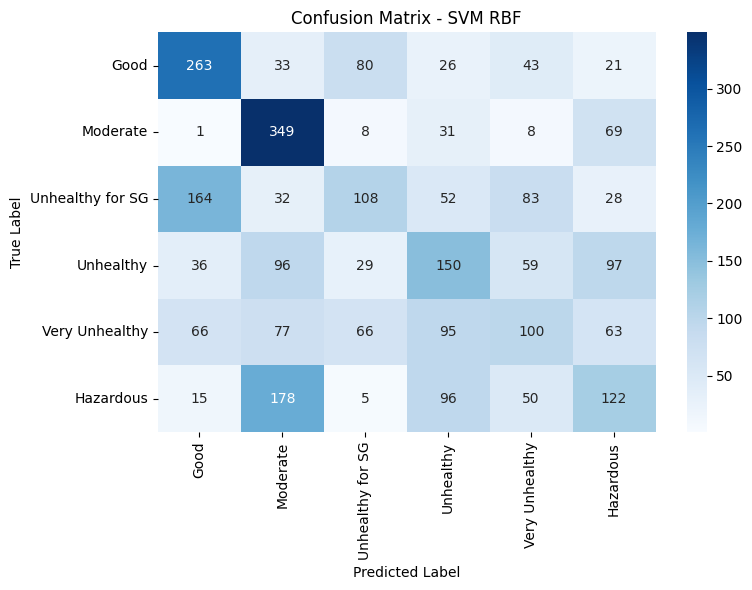


📊 Model: SVM Polynomial
------------------------------------------------------------
                  precision    recall  f1-score   support

            Good       0.51      0.43      0.47       466
        Moderate       0.37      0.82      0.51       466
Unhealthy for SG       0.37      0.16      0.23       467
       Unhealthy       0.26      0.15      0.19       467
  Very Unhealthy       0.26      0.24      0.25       467
       Hazardous       0.30      0.28      0.29       466

        accuracy                           0.35      2799
       macro avg       0.34      0.35      0.32      2799
    weighted avg       0.34      0.35      0.32      2799

✅ Accuracy: 0.3487


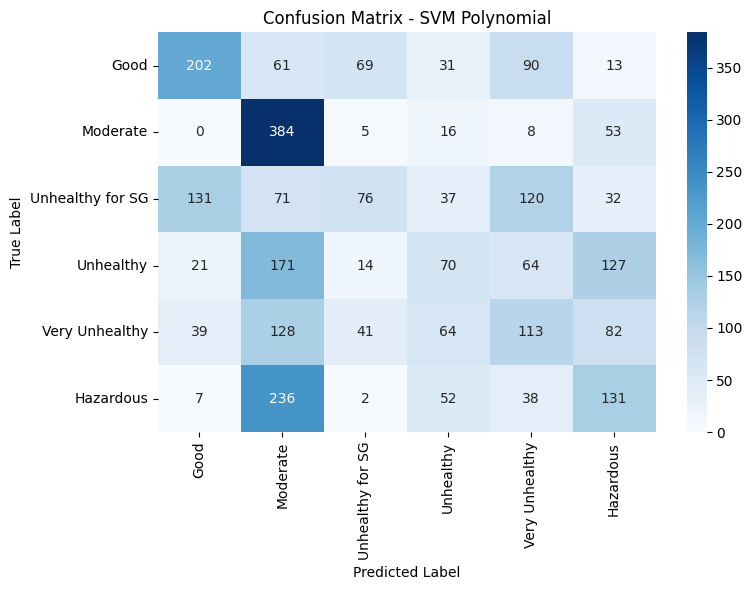

In [ ]:
# Labels (optional): set them based on your AQI categories if available
aqi_labels = ['Good', 'Moderate', 'Unhealthy for SG', 'Unhealthy', 'Very Unhealthy', 'Hazardous']

# Call the evaluation for each model: MinMaxScaler
evaluate_model("SVM Linear", y_test, y_pred_linear, labels=aqi_labels)
evaluate_model("SVM RBF", y_test, y_pred_rbf, labels=aqi_labels)
evaluate_model("SVM Polynomial", y_test, y_pred_poly, labels=aqi_labels)

# Call the evaluation for each model: StandardScaler
evaluate_model("SVM Linear", y_test, y_pred_linear_ss, labels=aqi_labels)
evaluate_model("SVM RBF", y_test, y_pred_rbf_ss, labels=aqi_labels)
evaluate_model("SVM Polynomial", y_test, y_pred_poly_ss, labels=aqi_labels)

In [ ]:
import numpy as np

class KernelSVM:
    def __init__(self, kernel='rbf', lambda_param=0.01, n_iters=1000, learning_rate=0.01, degree=3, gamma=None):
        self.kernel_type = kernel
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.lr = learning_rate
        self.degree = degree
        self.gamma = gamma  # For RBF kernel
        self.alpha = None
        self.X_train = None
        self.y_train = None

    def _kernel(self, X, Y=None):
        if Y is None:
            Y = X

        if self.kernel_type == 'linear':
            return X @ Y.T
        elif self.kernel_type == 'polynomial':
            return (1 + X @ Y.T) ** self.degree
        elif self.kernel_type == 'rbf':
            if self.gamma is None:
                self.gamma = 1.0 / X.shape[1]
            X_norm = np.sum(X**2, axis=1).reshape(-1, 1)
            Y_norm = np.sum(Y**2, axis=1).reshape(1, -1)
            return np.exp(-self.gamma * (X_norm + Y_norm - 2 * X @ Y.T))
        else:
            raise ValueError("Unknown kernel")

    def fit(self, X, y):
        n_samples = X.shape[0]
        y = np.where(y <= 0, -1, 1)
        self.alpha = np.zeros(n_samples)
        self.X_train = X
        self.y_train = y
        K = self._kernel(X)

        for it in range(self.n_iters):
            i = np.random.randint(0, n_samples)
            margin = y[i] * np.sum(self.alpha * y * K[:, i])
            if margin < 1:
                self.alpha[i] += self.lr
                self.alpha[i] = max(0, self.alpha[i])  # Projection step
            self.alpha *= (1 - self.lr * self.lambda_param)  # Regularization

    def project(self, X):
        K = self._kernel(X, self.X_train)
        return np.dot(K, self.alpha * self.y_train)

    def predict(self, X):
        return np.sign(self.project(X))



📊 Model: SVM Linear
------------------------------------------------------------
                  precision    recall  f1-score   support

            Good       0.00      0.00      0.00       466
        Moderate       0.17      1.00      0.29       466
Unhealthy for SG       0.00      0.00      0.00       467
       Unhealthy       0.00      0.00      0.00       467
  Very Unhealthy       0.00      0.00      0.00       467
       Hazardous       0.00      0.00      0.00       466

        accuracy                           0.17      2799
       macro avg       0.03      0.17      0.05      2799
    weighted avg       0.03      0.17      0.05      2799

✅ Accuracy: 0.1665


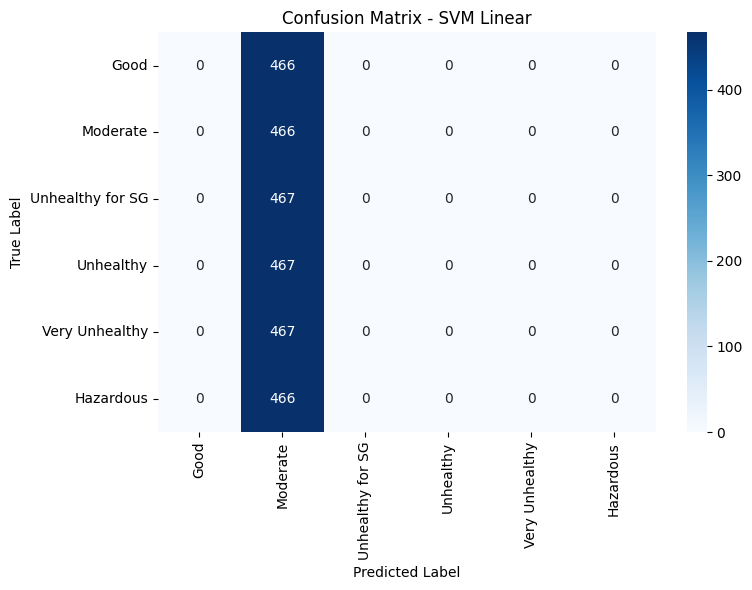


📊 Model: SVM RBF
------------------------------------------------------------


ValueError: Classification metrics can't handle a mix of multiclass and multilabel-indicator targets

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split


# Try linear kernel
svm_linear = KernelSVM(kernel='linear')
svm_linear.fit(X_train_scaled,y_train.values.ravel())
y_pred_linear_sc = svm_linear.predict(X_test_scaled)

# Try rbf kernel
svm_rbf = KernelSVM(kernel='rbf')
svm_rbf.fit(X_train_scaled, y_train.values)
y_pred_rbf_sc = svm_rbf.predict(X_test_scaled)

# Try polynomial kernel
svm_poly = KernelSVM(kernel='polynomial')
svm_poly.fit(X_train_scaled, y_train.values)
y_pred_poly_sc = svm_poly.predict(X_test_scaled)

# Call the evaluation for each model: StandardScaler
evaluate_model("SVM Linear", y_test, y_pred_linear_sc, labels=aqi_labels)
evaluate_model("SVM RBF", y_test, y_pred_rbf_sc, labels=aqi_labels)
evaluate_model("SVM Polynomial", y_test, y_pred_poly_sc, labels=aqi_labels)

In [ ]:
X_train_scaled.shape

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
param_grid = [
    {
        'svc__kernel': ['linear'],
        'svc__C': [0.1, 1, 10, 100]
    },
    {
        'svc__kernel': ['rbf'],
        'svc__C': [0.1, 1, 10],
        'svc__gamma': ['scale', 0.001, 0.01, 0.1]
    },
    {
        'svc__kernel': ['poly'],
        'svc__C': [0.1, 1, 10],
        'svc__degree': [2, 3, 4],
        'svc__gamma': ['scale', 0.01]
    }
]
param_dist = {
    'svc__kernel': ['linear', 'rbf', 'poly'],
    'svc__C': np.logspace(-2, 2, 10),
    'svc__gamma': ['scale', 'auto', 0.01, 0.001],
    'svc__degree': [2, 3, 4]  # Only used by 'poly'
}
pipe = Pipeline([
    ('scaler', StandardScaler()),  # Always scale your data for SVM
    ('svc', SVC())
])
grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print("Best GridSearchCV parameters:", grid_search.best_params_)
print(classification_report(y_test, grid_search.predict(X_test)))

random_search = RandomizedSearchCV(pipe, param_distributions=param_dist,
                                   n_iter=30, cv=5, n_jobs=-1, verbose=1, random_state=42)
random_search.fit(X_train, y_train)

print("Best RandomizedSearchCV parameters:", random_search.best_params_)
print(classification_report(y_test, random_search.predict(X_test)))


Fitting 5 folds for each of 34 candidates, totalling 170 fits


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best GridSearchCV parameters: {'svc__C': 10, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.50      0.59      0.54       466
           1       0.44      0.77      0.56       466
           2       0.41      0.24      0.31       467
           3       0.31      0.33      0.32       467
           4       0.35      0.22      0.27       467
           5       0.33      0.27      0.29       466

    accuracy                           0.40      2799
   macro avg       0.39      0.40      0.38      2799
weighted avg       0.39      0.40      0.38      2799

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best RandomizedSearchCV parameters: {'svc__kernel': 'rbf', 'svc__gamma': 'scale', 'svc__degree': 2, 'svc__C': np.float64(100.0)}
              precision    recall  f1-score   support

           0       0.51      0.61      0.56       466
           1       0.45      0.76      0.57       466
           2       0.41      0.23      0.29       467
           3       0.32      0.34      0.33       467
           4       0.32      0.23      0.27       467
           5       0.35      0.26      0.30       466

    accuracy                           0.41      2799
   macro avg       0.39      0.41      0.39      2799
weighted avg       0.39      0.41      0.39      2799



,DEWP,TEMP,PRES,Iws,Is,Ir
0,-6,-5.0,1022.0,5.81,0,0
1,14,22.0,1014.0,25.47,0,0
2,5,14.0,1009.0,16.97,0,0
3,21,27.0,1003.0,0.89,0,0
4,-6,4.0,1026.0,1.79,0,0
...,...,...,...,...,...,...
18655,10,18.0,1023.0,0.89,0,0
18656,20,21.0,1004.0,1.79,0,0
18657,7,22.0,1015.0,2.67,0,0
18658,14,15.0,1007.0,0.89,0,0


In [ ]:
y_reg = df_reg['pm2.5']
X_reg = df_reg.drop(columns=['pm2.5','AQI_Category'])
display(X_reg)
display(y_reg)

,year,month,day,hour,DEWP,TEMP,PRES,Iws,Is,Ir,...,pm2.5_lag_2h,pm2.5_lag_24h,pm2.5_roll_mean_24h,hour_sin,hour_cos,day_sin,day_cos,year_norm,year_sin,year_cos
24,2010,1,4,0,-14,-12.0,1023.0,16.09,0,0,...,76.0,90.0,78.375000,0.000000,1.000000,0.068802,0.997630,0,0.000000,1.000000
25,2010,1,4,1,-16,-9.0,1023.0,21.90,0,0,...,73.0,63.0,78.166667,0.258819,0.965926,0.068802,0.997630,0,0.000000,1.000000
26,2010,1,4,2,-17,-10.0,1024.0,29.95,0,0,...,79.0,65.0,76.500000,0.500000,0.866025,0.068802,0.997630,0,0.000000,1.000000
27,2010,1,4,3,-18,-11.0,1024.0,39.78,0,0,...,58.0,55.0,75.291667,0.707107,0.707107,0.068802,0.997630,0,0.000000,1.000000
28,2010,1,4,4,-19,-11.0,1025.0,48.72,0,0,...,25.0,65.0,73.750000,0.866025,0.500000,0.068802,0.997630,0,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43771,2014,12,31,19,-23,-2.0,1034.0,52.09,0,0,...,9.0,35.0,11.291667,-0.965926,0.258819,0.508671,0.860961,4,-0.951057,0.309017
43772,2014,12,31,20,-22,-3.0,1034.0,52.09,0,0,...,10.0,26.0,10.625000,-0.866025,0.500000,0.508671,0.860961,4,-0.951057,0.309017
43773,2014,12,31,21,-22,-3.0,1034.0,52.09,0,0,...,8.0,20.0,10.208333,-0.707107,0.707107,0.508671,0.860961,4,-0.951057,0.309017
43774,2014,12,31,22,-22,-4.0,1034.0,52.09,0,0,...,10.0,8.0,10.208333,-0.500000,0.866025,0.508671,0.860961,4,-0.951057,0.309017


,pm2.5
24,79.0
25,58.0
26,25.0
27,26.0
28,28.0
...,...
43771,8.0
43772,10.0
43773,10.0
43774,8.0


In [ ]:
split_idx = int(len(X) * 0.8)
X_train_reg, X_test_reg = X_reg[:split_idx], X_reg[split_idx:]
y_train_reg, y_test_reg = y_reg[:split_idx], y_reg[split_idx:]
print(X_train_reg.shape)
print(X_test_reg.shape)
print(y_train_reg.shape)
print(y_test_reg.shape)

(35059, 21)
(8693, 21)
(35059,)
(8693,)


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled_reg = scaler_X.fit_transform(X_train_reg)
X_test_scaled_reg = scaler_X.transform(X_test_reg)

y_train_scaled_reg = scaler_y.fit_transform(y_train_reg.values.reshape(-1, 1)).ravel()

In [ ]:
from sklearn.svm import SVR

svr = SVR(kernel='rbf', C=10, epsilon=0.1, gamma=0.01)
svr.fit(X_train_scaled_reg, y_train_scaled_reg)

# Predict
y_pred_scaled_reg = svr.predict(X_test_scaled_reg)

# Inverse transform to original scale
y_pred_reg = scaler_y.inverse_transform(y_pred_scaled_reg.reshape(-1, 1)).ravel()

In [ ]:
y_test_reg

,pm2.5
35083,46.0
35084,50.0
35085,68.0
35086,60.0
35087,103.0
...,...
43771,8.0
43772,10.0
43773,10.0
43774,8.0


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,accuracy_score

print("MAE:", mean_absolute_error(y_test_reg, y_pred_reg))
print("MSE:", mean_squared_error(y_test_reg, y_pred_reg))
print("RMSE:", np.sqrt(mean_squared_error(y_test_reg, y_pred_reg)))
print("R² Score:", r2_score(y_test_reg, y_pred_reg))


MAE: 18.288769293326524
MSE: 744.8438969375984
RMSE: 27.29182839125291
R² Score: 0.8858004523308705


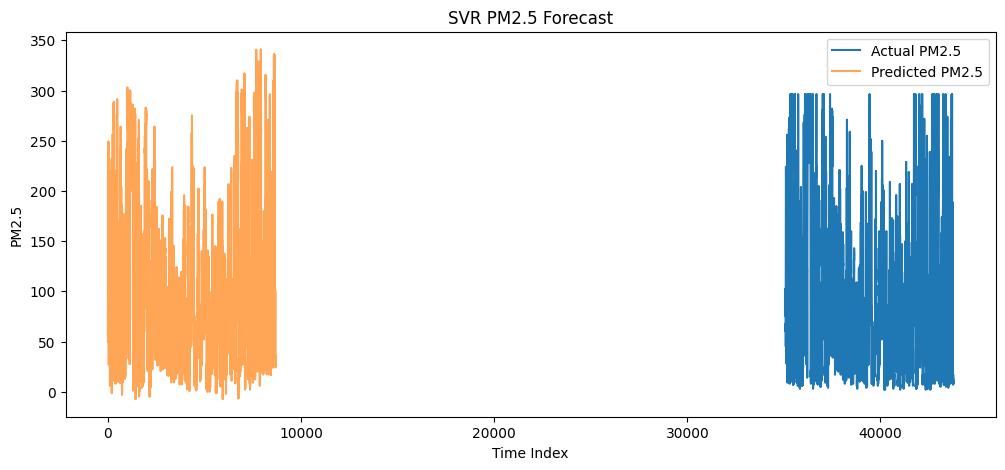

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(y_test_reg, label='Actual PM2.5')
plt.plot(y_pred_reg, label='Predicted PM2.5', alpha=0.7)
plt.legend()
plt.title("SVR PM2.5 Forecast")
plt.xlabel("Time Index")
plt.ylabel("PM2.5")
plt.show()


In [ ]:
df_paper_im = df_model.copy()
df_paper_im.drop(columns=['cbwd','year','month','day','hour'],inplace=True)
df_paper_im['aqi'] = df_paper_im['pm2.5'].apply(categorize_aqi)
df_paper_im

,DEWP,TEMP,PRES,Iws,Is,Ir,pm2.5,cbwd_numerical,aqi
0,-16,-4.0,1020.0,1.79,0,0,129.0,2,Unhealthy
1,-15,-4.0,1020.0,2.68,0,0,148.0,2,Unhealthy
2,-11,-5.0,1021.0,3.57,0,0,159.0,2,Very Unhealthy
3,-7,-5.0,1022.0,5.36,1,0,181.0,2,Very Unhealthy
4,-7,-5.0,1022.0,6.25,2,0,138.0,2,Unhealthy
...,...,...,...,...,...,...,...,...,...
43795,-23,-2.0,1034.0,52.09,0,0,8.0,1,Good
43796,-22,-3.0,1034.0,52.09,0,0,10.0,1,Good
43797,-22,-3.0,1034.0,52.09,0,0,10.0,1,Good
43798,-22,-4.0,1034.0,52.09,0,0,8.0,1,Good


In [ ]:
df_paper_im['aqi'].value_counts()

,count
aqi,
Unhealthy,16405
Moderate,9151
Very Unhealthy,6160
Unhealthy for Sensitive Groups,5267
Good,3707
Hazardous,3110


In [ ]:
import pandas as pd
from sklearn.utils import resample

def downsample_to_balance(df, target_column):
    """
    Detects class imbalance in the target column of a DataFrame and
    applies downsampling to balance the classes.

    Parameters:
    -----------
    df : pd.DataFrame
        The input dataset.
    target_column : str
        The name of the target/class column.

    Returns:
    --------
    pd.DataFrame
        A balanced DataFrame using downsampling.
    """
    # Check class distribution
    class_counts = df[target_column].value_counts()
    print("Original class distribution:\n", class_counts)

    # Identify the minority class count
    min_count = class_counts.min()

    # Downsample each class to the size of the minority class
    balanced_df_list = []
    for cls in class_counts.index:
        cls_subset = df[df[target_column] == cls]
        cls_downsampled = resample(cls_subset,
                                   replace=False,
                                   n_samples=min_count,
                                   random_state=42)
        balanced_df_list.append(cls_downsampled)

    # Combine the downsampled subsets
    balanced_df = pd.concat(balanced_df_list)

    # Shuffle the result
    balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

    print("\nBalanced class distribution:\n", balanced_df[target_column].value_counts())

    return balanced_df

In [ ]:
df_paper_im_balanced = downsample_to_balance(df_paper_im,'aqi')
df_paper_im_balanced
X_paper = df_paper_im_balanced.drop(columns=['aqi','pm2.5'])
y_paper = df_paper_im_balanced['aqi']
Encoder = LabelEncoder()
y_paper = pd.DataFrame(Encoder.fit_transform(y_paper))
display(X_paper)
display(y_paper)
X_paper_sub , x_paper_sub_test , y_paper_sub, y_paper_sub_test = train_test_split(X_paper, y_paper, train_size=0.2, random_state=42)
display(X_paper_sub)
display(y_paper_sub)

Original class distribution:
 aqi
Unhealthy                         16405
Moderate                           9151
Very Unhealthy                     6160
Unhealthy for Sensitive Groups     5267
Good                               3707
Hazardous                          3110
Name: count, dtype: int64

Balanced class distribution:
 aqi
Moderate                          3110
Unhealthy                         3110
Good                              3110
Unhealthy for Sensitive Groups    3110
Hazardous                         3110
Very Unhealthy                    3110
Name: count, dtype: int64


,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_numerical
0,-17,10.0,1020.0,9.83,0,0,2
1,2,18.0,1020.0,4.02,0,0,2
2,5,14.0,1009.0,16.97,0,0,2
3,-6,20.0,1013.0,1.79,0,0,2
4,5,27.0,1012.0,36.66,0,0,1
...,...,...,...,...,...,...,...
18655,-7,22.0,1001.0,44.70,0,0,1
18656,-24,4.0,1030.0,4.02,0,0,2
18657,-17,11.0,1023.0,4.92,0,0,0
18658,14,15.0,1007.0,0.89,0,0,3


,0
0,2
1,2
2,3
3,2
4,0
...,...
18655,4
18656,4
18657,2
18658,3


,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_numerical
3811,16,23.0,1007.0,2.67,0,0,3
14197,-15,-9.0,1029.0,1.34,0,0,3
17464,-13,-8.0,1034.0,0.89,0,0,3
3450,-17,1.0,1026.0,8.94,0,0,1
4591,-10,-3.0,1031.0,29.51,0,0,2
...,...,...,...,...,...,...,...
11284,-24,-7.0,1030.0,52.09,0,0,1
11964,16,20.0,1009.0,4.02,0,0,1
5390,-4,-3.0,1020.0,1.79,0,0,1
860,20,25.0,1004.0,1.79,0,0,2


,0
3811,3
14197,0
17464,5
3450,4
4591,3
...,...
11284,0
11964,4
5390,1
860,5


In [ ]:
import numpy as np
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from scipy.optimize import differential_evolution


def svm_fitness(params):
    C, gamma = params
    clf = make_pipeline(
        StandardScaler(),
        SVC(C=C, gamma=gamma, kernel='rbf')
    )
    # Use cross-validation to evaluate performance
    scores = cross_val_score(clf, X_paper_sub, y_paper_sub, cv=5)
    return -scores.mean()  # We want to maximize accuracy, so we minimize negative

param_bounds = [
    (1, 1e2),  # C
    (1e-4, 1)   # gamma
]

result = differential_evolution(
    svm_fitness,
    bounds=param_bounds,
    strategy='best1bin',
    maxiter=50,
    popsize=15,
    tol=0.01,
    seed=42
)

best_C, best_gamma = result.x
print(f"Best parameters: C={best_C:.4f}, gamma={best_gamma:.4f}")

# 5. Train final model
final_model = make_pipeline(
    StandardScaler(),
    SVC(C=best_C, gamma=best_gamma, kernel='rbf')
)
final_model.fit(X_paper_sub, y_paper_sub)
print("Final model trained.")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Best parameters: C=5.3620, gamma=0.3565


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Final model trained.


In [ ]:
pip install pyswarms

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 4.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from pyswarms.single.global_best import GlobalBestPSO

def objective_function(params):
    C = params[:, 0]
    gamma = params[:, 1]
    epsilon = params[:, 2]
    losses = []
    for i in range(params.shape[0]):
        model = SVR(kernel='rbf', C=C[i], gamma=gamma[i], epsilon=epsilon[i])
        score = cross_val_score(model, X_paper_sub, y_paper_sub, cv=3, scoring='neg_mean_squared_error')
        losses.append(-score.mean())  # minimize MSE
    return np.array(losses)

bounds = (np.array([1, 0.0001, 0.01]), np.array([1000, 1, 1]))  # C, gamma, epsilon
options = {'c1': 1.5, 'c2': 1.5, 'w': 0.7}

optimizer = GlobalBestPSO(n_particles=10, dimensions=3, options=options, bounds=bounds)
best_cost, best_params = optimizer.optimize(objective_function, iters=10)

print(f"\n Optimized Parameters:")
print(f"C = {best_params[0]:.4f}, gamma = {best_params[1]:.4f}, epsilon = {best_params[2]:.4f}")


2025-06-01 10:31:48,366 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/10/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages


 Optimized Parameters:
C = 211.5221, gamma = 0.2737, epsilon = 0.9696


In [ ]:
# 5. مدل بهینه‌شده
svr_optimized = SVR(kernel='rbf', C=best_params[0], gamma=best_params[1], epsilon=best_params[2])
svr_optimized.fit(X_paper_sub, y_paper_sub)

y_pred_scaled = svr_optimized.predict(X_paper_sub)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))

# 6. مدل پیش‌فرض
svr_default = SVR(kernel='rbf')
svr_default.fit(X_paper_sub, y_paper_sub)
y_pred_default_scaled = svr_default.predict(X_paper_sub)
y_pred_default = scaler_y.inverse_transform(y_pred_default_scaled.reshape(-1, 1))

# 7. ارزیابی
mse_opt = mean_squared_error(y_paper_sub, y_pred)
r2_opt = r2_score(y_paper_sub, y_pred)

mse_def = mean_squared_error(y_paper_sub, y_pred_default)
r2_def = r2_score(y_paper_sub, y_pred_default)

print("\nModel Summary:")
print(f"Model optimized with PSO: {mse_opt:.4f}, R2: {r2_opt:.4f}")
print(f"The General Model for SVM: {mse_def:.4f}, R2: {r2_def:.4f}")



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Model Summary:
Model optimized with PSO: 89972.2724, R2: -30962.5617
The General Model for SVM: 85495.8632, R2: -29422.0251


In [ ]:
print(y_pred.shape)
print(y_paper_sub_test.shape)

(3732, 1)
(14928, 1)
